In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import statsmodels.api as sm
import scipy.stats as stats
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy.stats import jarque_bera, anderson
from sklearn.decomposition import PCA
from scipy.stats import t
from statsmodels.tsa.stattools import adfuller

plt.style.use("seaborn-v0_8")

In [2]:
px_common = pd.read_csv("E:\data\stock_prices.csv",index_col="date",parse_dates=True,encoding="utf-8")

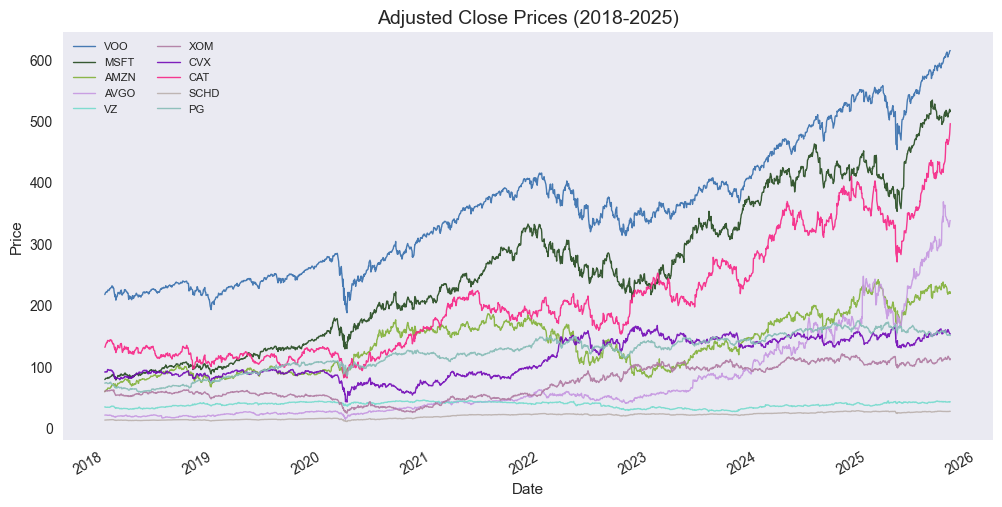

In [3]:
colors = [
    "#356EAC",  
    "#23491E", 
    "#82B138",  
    "#c697e1",  
    "#75dbcd",  
    "#B07AA1",  
    "#7209B7",  
    "#F72585",  
    "#BAB0AC",  
    "#86BCB6"   
]

plt.figure(figsize=(12, 6))
px_common.plot(ax=plt.gca(),color=colors,linewidth=1,alpha=0.9)
plt.title("Adjusted Close Prices (2018-2025)", fontsize=14)
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend(loc="upper left", ncol=2, fontsize=8, frameon=False)
ax = plt.gca()
ax.grid(False)
ax.spines["top"].set_visible(False)
plt.show()

## 2. Log-returns

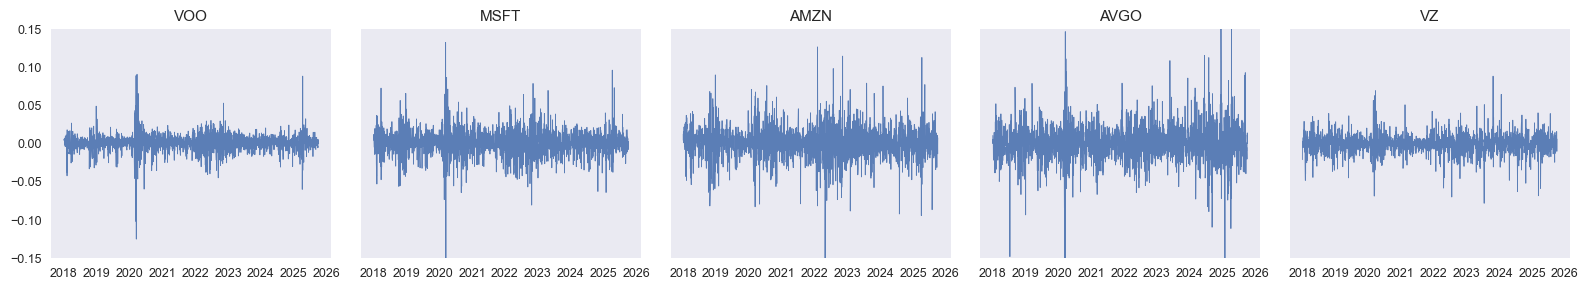

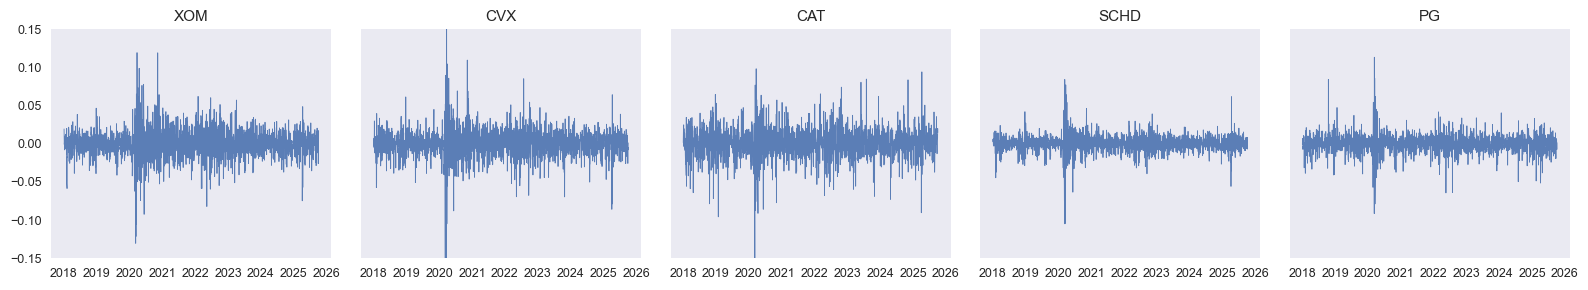

In [4]:
assets_groups = {
    "group1": ["VOO", "MSFT", "AMZN", "AVGO", "VZ"],
    "group2": ["XOM", "CVX", "CAT", "SCHD", "PG"]
}

rets = np.log(px_common / px_common.shift(1)).dropna()

ymin, ymax = -0.15, 0.15

for _, assets in assets_groups.items():

    fig, axes = plt.subplots(1, 5, figsize=(16, 3), sharey=True)

    for ax, asset in zip(axes, assets):
        ax.plot(
            rets.index,
            rets[asset],
            lw=0.6,
            alpha=0.9
        )
        ax.set_title(asset, fontsize=11)
        ax.set_ylim(ymin, ymax)
        ax.tick_params(axis="both", labelsize=9)

        # clean academic look
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.grid(False)

    fig.tight_layout()
    plt.show()


In [5]:
rets = px_common.pct_change().dropna()
desc_stats = rets.describe().T

desc_stats["skewness"] = rets.skew()
desc_stats["kurtosis"] = rets.kurt()

desc_stats = desc_stats[
    ["mean","std","min","25%","50%","75%","max","skewness","kurtosis",]
]
desc_stats = desc_stats.round(3)
display(desc_stats)

,mean,std,min,25%,50%,75%,max,skewness,kurtosis
VOO,0.001,0.012,-0.117,-0.004,0.001,0.007,0.095,-0.347,13.848
MSFT,0.001,0.018,-0.147,-0.007,0.001,0.010,0.142,0.081,7.049
AMZN,0.001,0.022,-0.140,-0.010,0.001,0.012,0.135,0.070,4.222
AVGO,0.002,0.026,-0.199,-0.011,0.001,0.014,0.244,0.305,11.395
VZ,0.000,0.013,-0.075,-0.006,0.000,0.007,0.093,0.001,5.788
XOM,0.001,0.019,-0.122,-0.010,0.000,0.011,0.127,-0.003,5.399
CVX,0.000,0.020,-0.221,-0.008,0.001,0.009,0.227,-0.311,23.137
CAT,0.001,0.020,-0.143,-0.009,0.001,0.012,0.103,-0.194,4.111
SCHD,0.000,0.012,-0.099,-0.005,0.001,0.006,0.088,-0.303,12.794
PG,0.000,0.013,-0.087,-0.006,0.001,0.007,0.120,0.170,11.239


 ## 2. Correlation Analysis

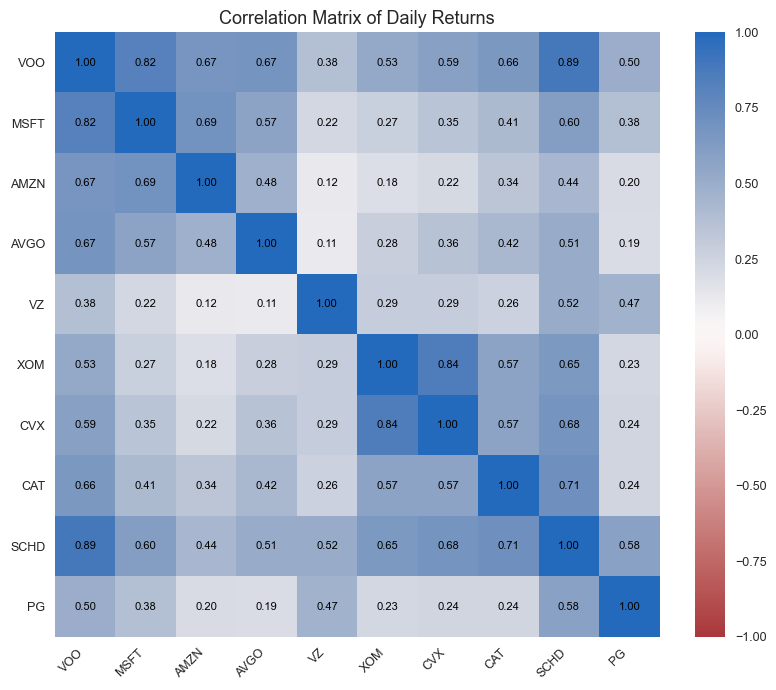

In [6]:
corr = rets.corr()
n = corr.shape[0]

fig, ax = plt.subplots(figsize=(8, 7))

im = ax.imshow(
    corr.values,
    cmap="vlag_r",
    vmin=-1, vmax=1,
    interpolation="nearest",
    origin="upper",
    aspect="equal"
)

cbar = fig.colorbar(im, ax=ax, fraction=0.046)
cbar.ax.tick_params(labelsize=9)

ax.set_xticks(np.arange(n))
ax.set_yticks(np.arange(n))
ax.set_xticklabels(corr.columns, rotation=45, ha="right", fontsize=9)
ax.set_yticklabels(corr.columns, fontsize=9)

ax.set_xlim(-0.5, n - 0.5)
ax.set_ylim(n - 0.5, -0.5)

ax.grid(False)
ax.tick_params(which="both", length=0)

for i in range(n):
    for j in range(n):
        ax.text(
            j, i,
            f"{corr.iloc[i, j]:.2f}",
            ha="center", va="center",
            fontsize=8,
            color="black"
        )

ax.set_title("Correlation Matrix of Daily Returns", fontsize=13)

for spine in ax.spines.values():
    spine.set_visible(False)

plt.tight_layout()
plt.show()

## 2. Distribution of Returns

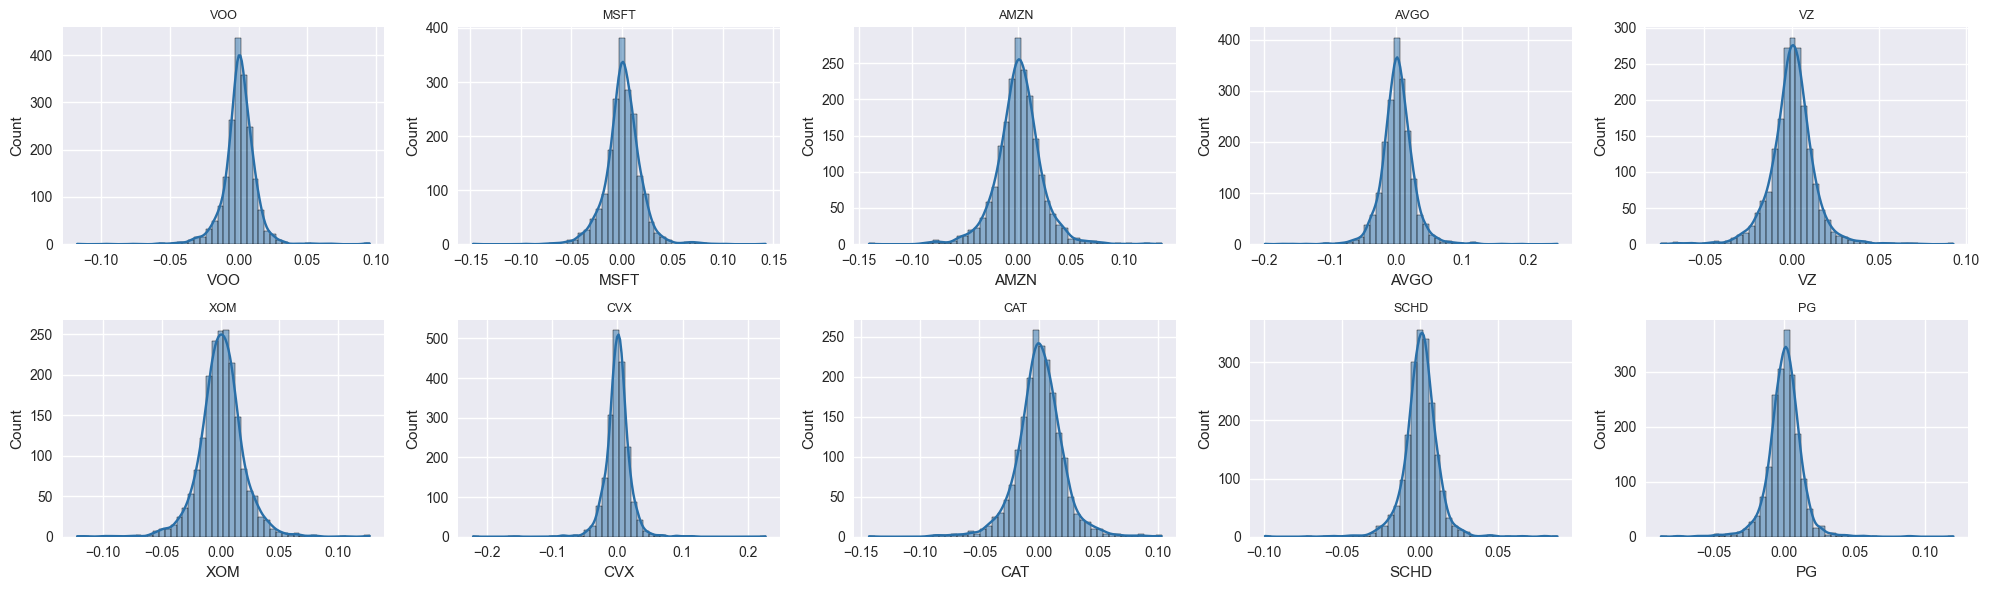

In [7]:
n_assets = len(rets.columns)
cols = 5  
rows = math.ceil(n_assets / cols)

plt.figure(figsize=(4*cols, 3*rows))
for i, col in enumerate(rets.columns, 1):
    plt.subplot(rows, cols, i)
    sns.histplot(rets[col], bins=50, kde=True, color="#296FA8")
    plt.title(col, fontsize=9)
plt.tight_layout()
plt.show()

## 4. Rolling Volatility of Log-Returns

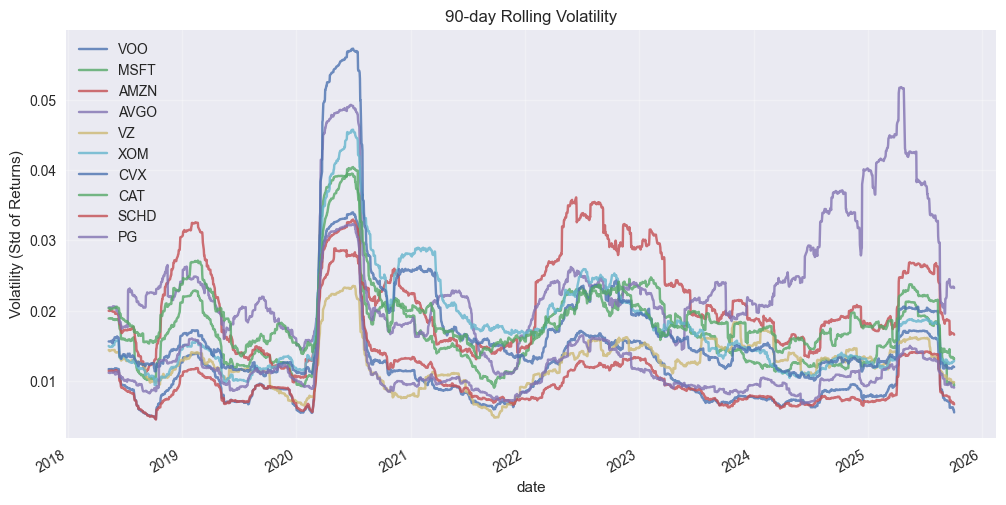

In [8]:
rolling_vol = rets.rolling(window=90).std() 

plt.figure(figsize=(12,6))
rolling_vol.plot(ax=plt.gca(), alpha=0.8)
plt.title("90-day Rolling Volatility")
plt.ylabel("Volatility (Std of Returns)")
plt.grid(True, alpha=0.3)
plt.show()

In [9]:
rf = 0.02
mu = rets.mean() * 252
sigma = rets.std(ddof=0) * np.sqrt(252)

sharpe = (mu - rf) / sigma
sharpe.sort_values(ascending=False)

AVGO    1.030866
MSFT    0.922361
VOO     0.679071
CAT     0.637785
AMZN    0.604635
SCHD    0.501078
PG      0.467138
XOM     0.360178
CVX     0.308709
VZ      0.137466
dtype: float64

In [10]:
def adf_summary(data, alpha=0.05):
    rows = []
    for col in data.columns:
        stat, pval, _, _, crit, _ = adfuller(data[col].dropna(), autolag="AIC")
        rows.append({
            "Asset": col,
            "ADF Stat": stat,
            "p-value": pval,
            "Stationary": "Yes" if pval < alpha else "No"
        })
    return pd.DataFrame(rows)

adf_prices = adf_summary(px_common)
adf_returns = adf_summary(rets)

In [11]:
adf_prices

,Asset,ADF Stat,p-value,Stationary
0,VOO,0.646128,0.988699,No
1,MSFT,0.070042,0.963955,No
2,AMZN,-1.410901,0.577039,No
3,AVGO,2.843754,1.000000,No
4,VZ,-2.051246,0.264565,No
5,XOM,-0.573383,0.876884,No
6,CVX,-1.168576,0.686965,No
7,CAT,1.214557,0.996085,No
8,SCHD,-0.698064,0.847250,No
9,PG,-1.422474,0.571456,No


In [12]:
adf_returns

,Asset,ADF Stat,p-value,Stationary
0,VOO,-13.980730,4.182190e-26,Yes
1,MSFT,-14.716204,2.797474e-27,Yes
2,AMZN,-45.778858,0.000000e+00,Yes
3,AVGO,-16.637581,1.645325e-29,Yes
4,VZ,-24.123206,0.000000e+00,Yes
5,XOM,-15.847445,9.535001e-29,Yes
6,CVX,-15.273287,4.684982e-28,Yes
7,CAT,-12.954598,3.321403e-24,Yes
8,SCHD,-13.609258,1.887015e-25,Yes
9,PG,-12.220964,1.107581e-22,Yes


## Autocorrelation of log-returns

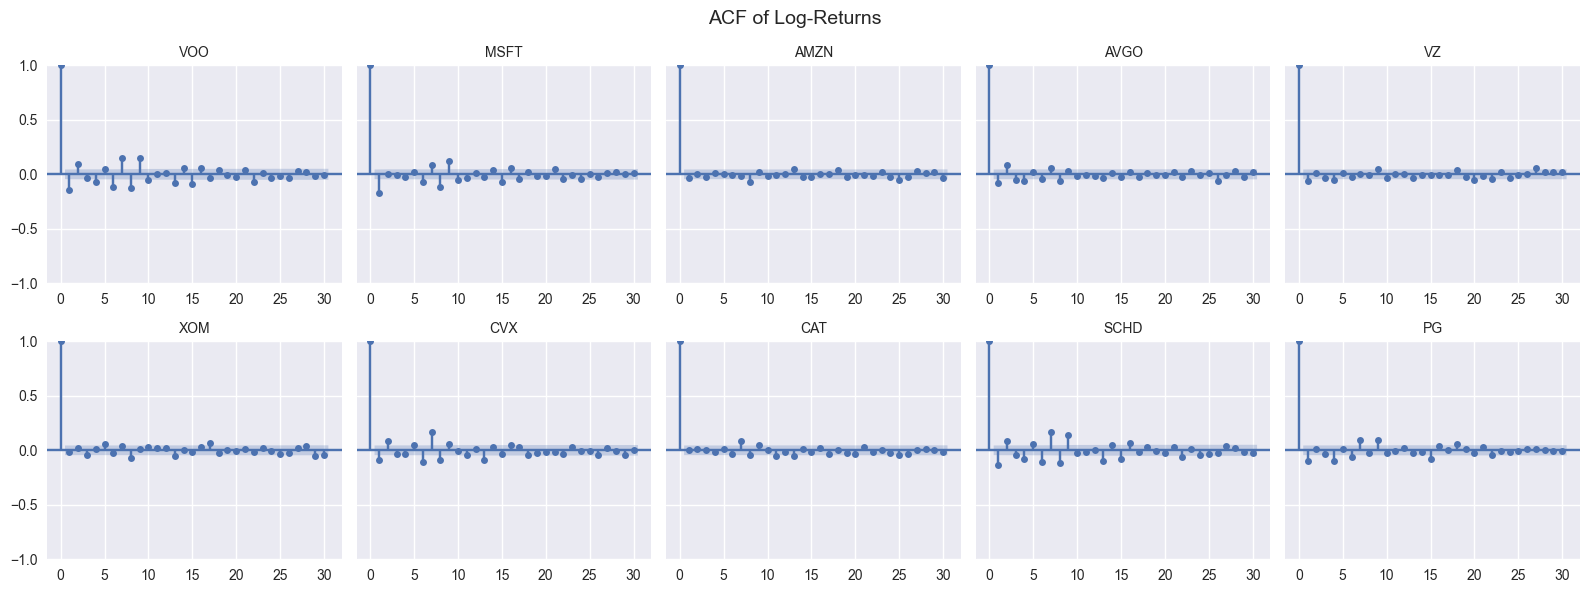

In [13]:
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt

assets = rets.columns

fig, axes = plt.subplots(2, 5, figsize=(16, 6), sharey=True)
axes = axes.flatten()

for ax, asset in zip(axes, assets):
    plot_acf(
        rets[asset].dropna(),
        ax=ax,
        lags=30,
        alpha=0.05
    )
    ax.set_title(asset, fontsize=10)
    ax.set_xlabel("")
    ax.set_ylabel("")

fig.suptitle("ACF of Log-Returns", fontsize=14)
plt.tight_layout()
plt.show()


## Partial Autocorrelation of Log-returns

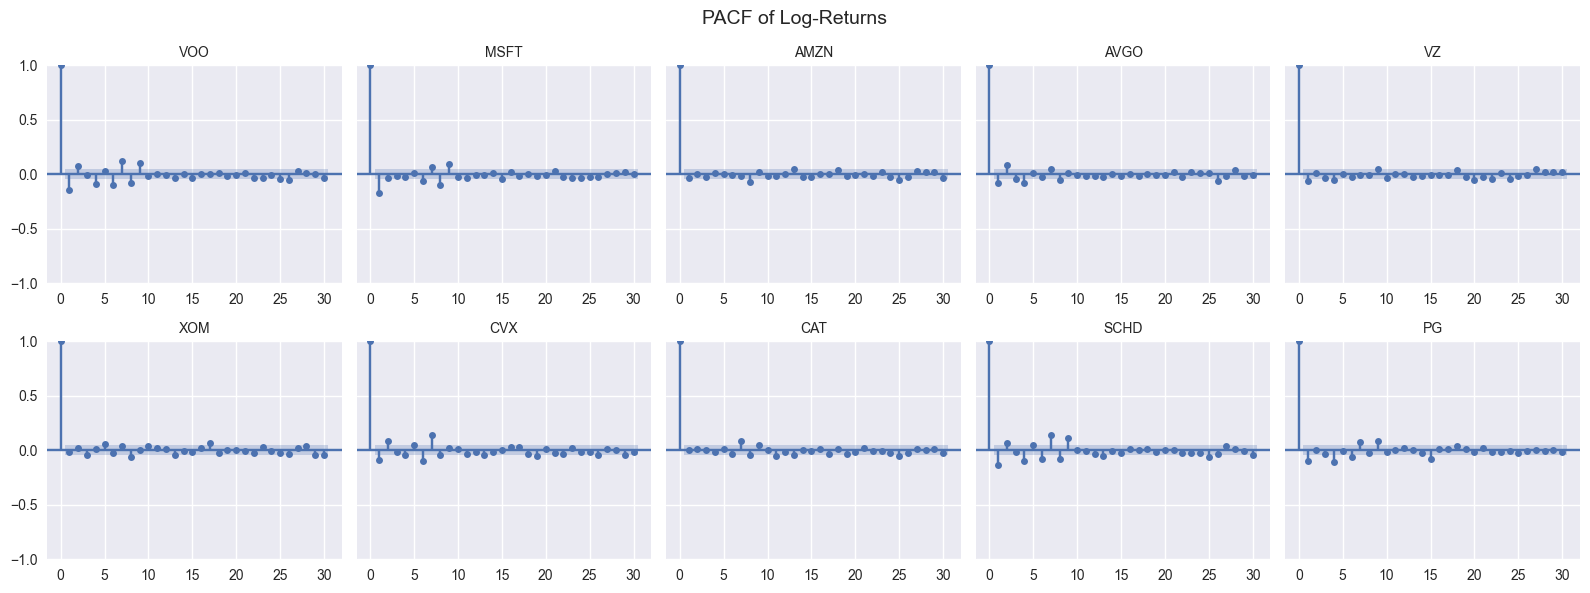

In [14]:
from statsmodels.graphics.tsaplots import plot_pacf

fig, axes = plt.subplots(2, 5, figsize=(16, 6), sharey=True)
axes = axes.flatten()

for ax, asset in zip(axes, assets):
    plot_pacf(
        rets[asset].dropna(),
        ax=ax,
        lags=30,
        alpha=0.05,
        method="ywm"
    )
    ax.set_title(asset, fontsize=10)
    ax.set_xlabel("")
    ax.set_ylabel("")

fig.suptitle("PACF of Log-Returns", fontsize=14)
plt.tight_layout()
plt.show()


## Principal Components Analysis

### 1. PCA 

In [15]:
n_components = 5
pca = PCA(n_components=n_components)
pcs = pca.fit_transform(rets)

pc_df = pd.DataFrame(
    pcs,
    index=rets.index,
    columns=[f"PC{i+1}" for i in range(n_components)]
)

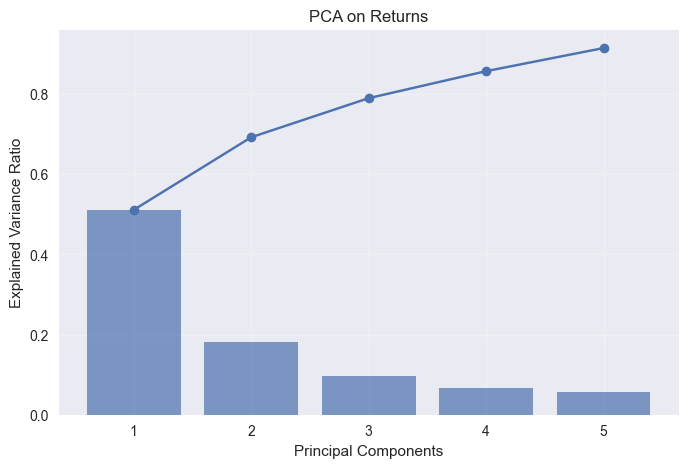

In [16]:
def plot_pca_explained_variance(pca):
    plt.figure(figsize=(8, 5))
    plt.bar(
        range(1, len(pca.explained_variance_ratio_) + 1),pca.explained_variance_ratio_,alpha=0.7)
    plt.plot(
        range(1, len(pca.explained_variance_ratio_) + 1), np.cumsum(pca.explained_variance_ratio_),marker="o")
    plt.xlabel("Principal Components")
    plt.ylabel("Explained Variance Ratio")
    plt.title("PCA on Returns")
    plt.grid(alpha=0.3)
    plt.show()

plot_pca_explained_variance(pca)


### Correlation of Principal Components with Assets Returns

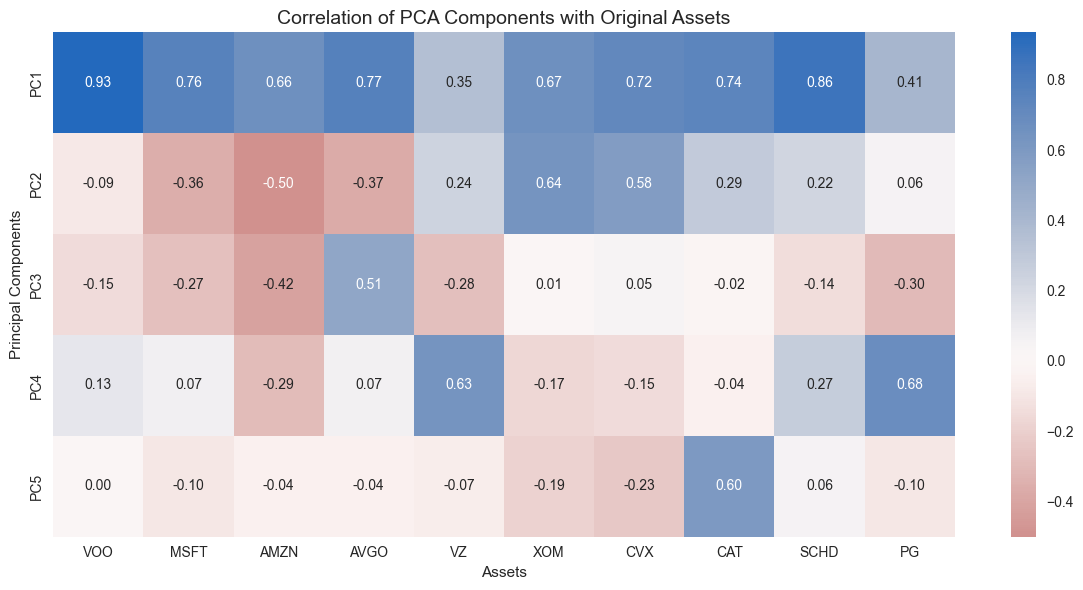

Total variance explained by first 5 components: 91.54%


In [17]:
def plot_pca_component_correlation(data, n_components=5):
    pca = PCA(n_components=n_components)
    components = pca.fit_transform(data)

    comp_df = pd.DataFrame(components, index=data.index,
                           columns=[f"PC{i+1}" for i in range(n_components)])

    # --- 3. Correlation between components & original assets ---
    corr = pd.DataFrame(index=comp_df.columns, columns=data.columns)
    for pc in comp_df.columns:
        corr.loc[pc] = data.corrwith(comp_df[pc])

    corr = corr.astype(float)

    plt.figure(figsize=(12, 6))
    sns.heatmap(corr, cmap="vlag_r", annot=True, fmt=".2f", center=0)
    plt.title("Correlation of PCA Components with Original Assets", fontsize=14)
    plt.xlabel("Assets")
    plt.ylabel("Principal Components")
    plt.tight_layout()
    plt.show()


    evr = pca.explained_variance_ratio_
    total_var = evr.sum() * 100
    print(f"Total variance explained by first {n_components} components: {total_var:.2f}%")

    return corr

corr_matrix = plot_pca_component_correlation(rets, n_components=5)

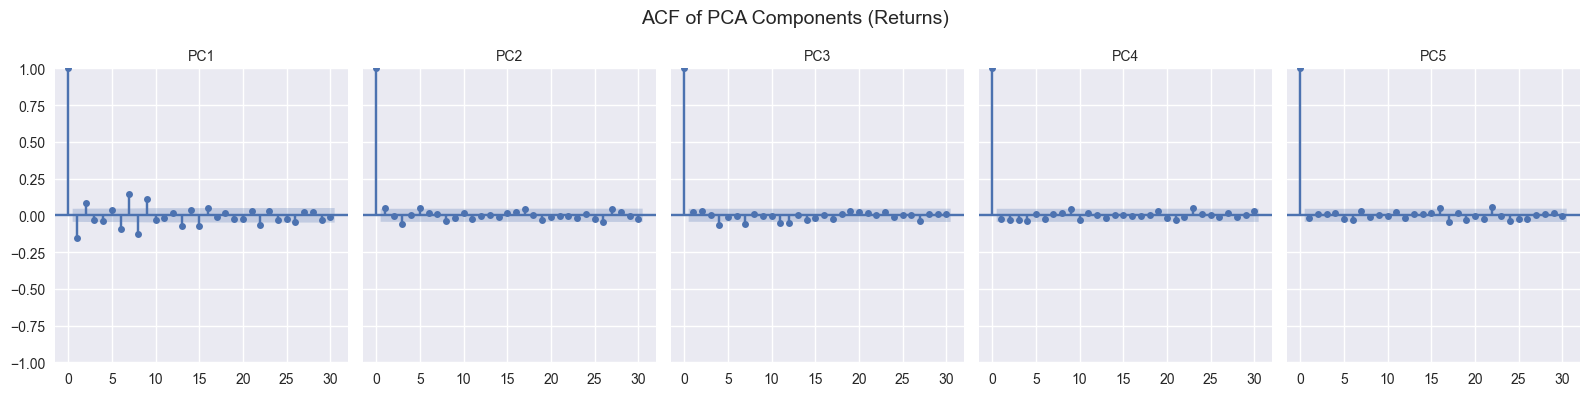

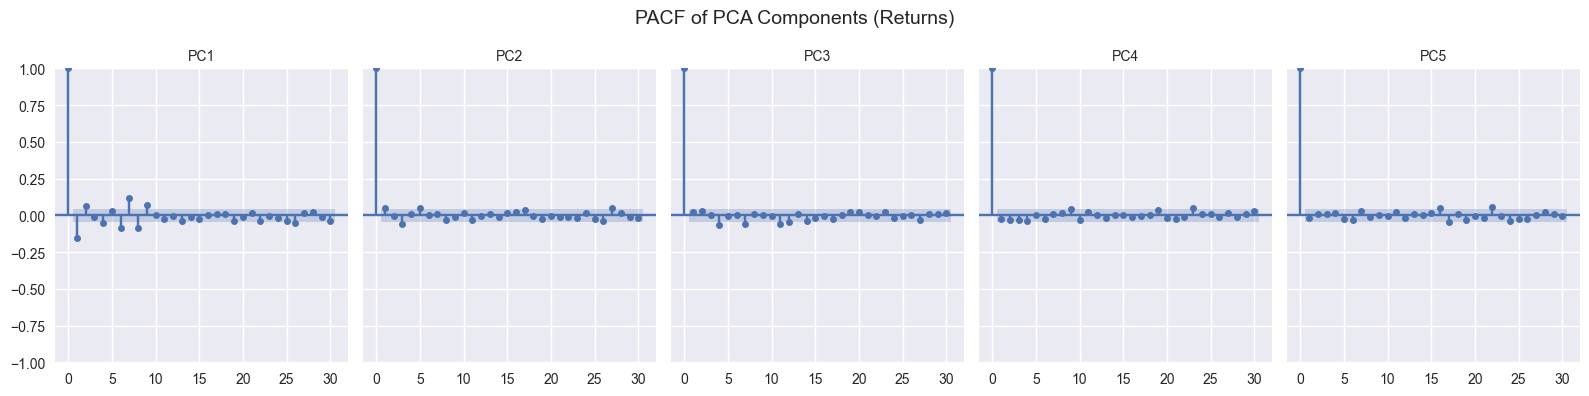

In [18]:
fig, axes = plt.subplots(1, 5, figsize=(16, 4), sharey=True)

for ax, col in zip(axes, pc_df.columns):
    plot_acf(pc_df[col].dropna(), ax=ax, lags=30, alpha=0.05)
    ax.set_title(col, fontsize=10)
    ax.set_xlabel("")
    ax.set_ylabel("")

fig.suptitle("ACF of PCA Components (Returns)", fontsize=14)
plt.tight_layout()

fig, axes = plt.subplots(1, 5, figsize=(16, 4), sharey=True)

for ax, col in zip(axes, pc_df.columns):
    plot_pacf(
        pc_df[col].dropna(),
        ax=ax,
        lags=30,
        alpha=0.05,
        method="ywm"
    )
    ax.set_title(col, fontsize=10)
    ax.set_xlabel("")
    ax.set_ylabel("")

fig.suptitle("PACF of PCA Components (Returns)", fontsize=14)
plt.tight_layout()
plt.show()

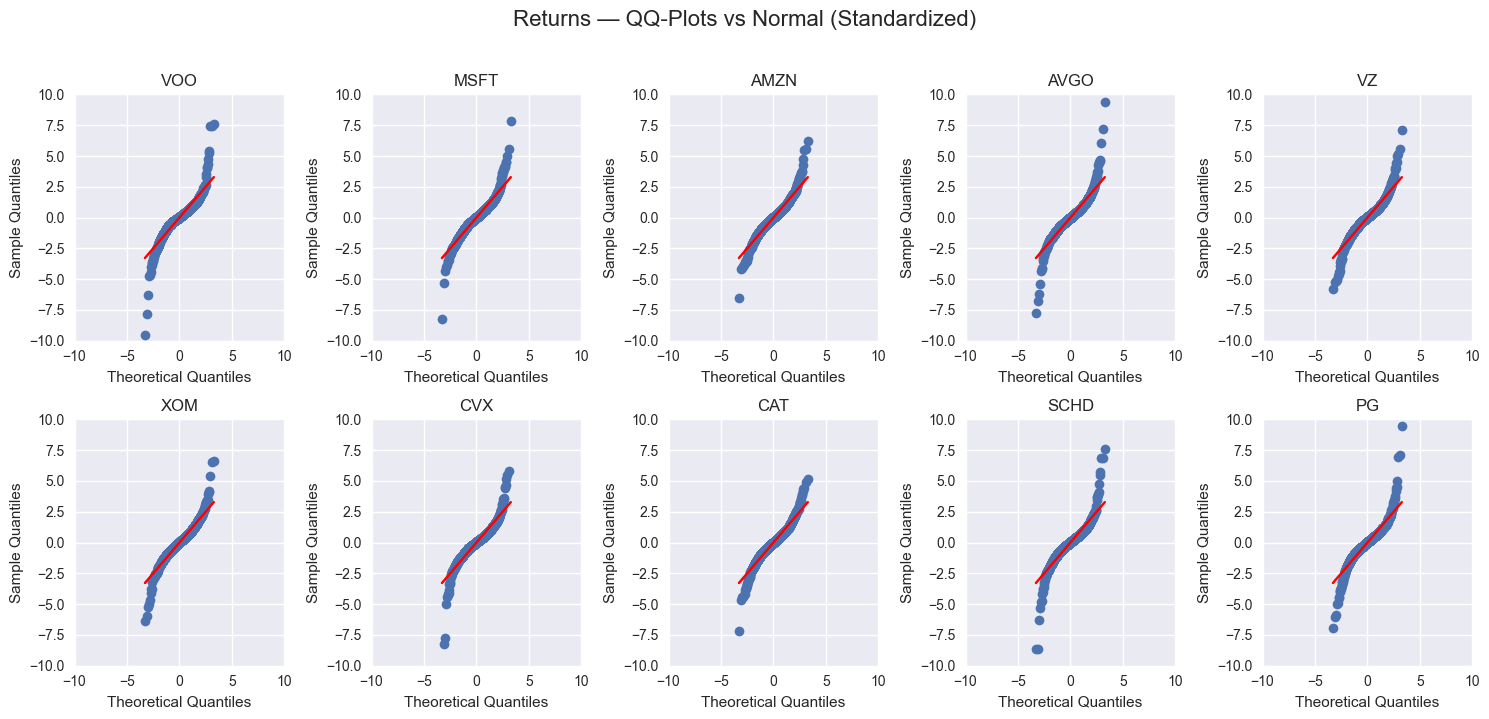

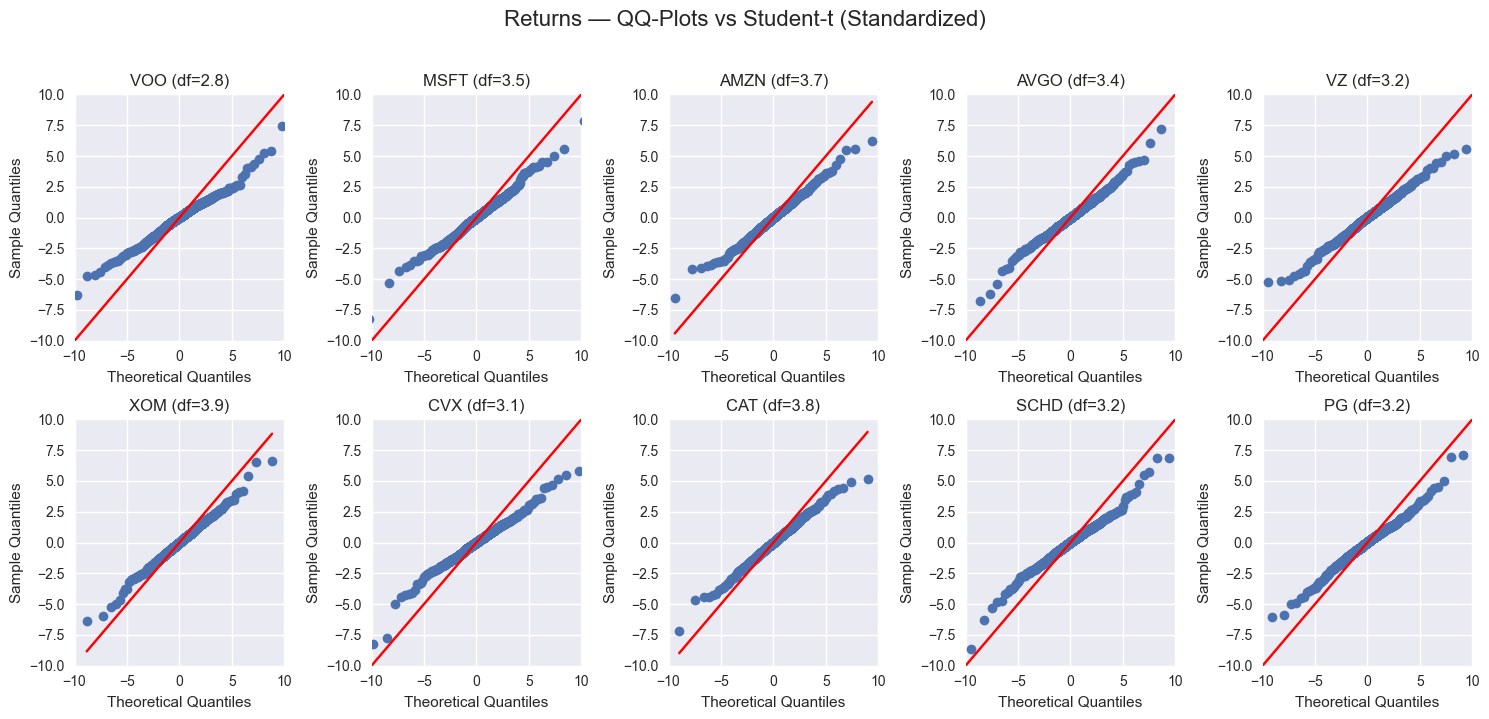

In [19]:
def plot_qq_distributions_grid(data, title_prefix="Returns"):
    assets = list(data.columns)
    ncols = 5
    nrows = 2

    # NORMAL 
    fig, axes = plt.subplots(nrows, ncols, figsize=(15, 7))
    fig.suptitle(f"{title_prefix} — QQ-Plots vs Normal (Standardized)", fontsize=16, y=1.02)

    for i, asset in enumerate(assets[:nrows * ncols]):
        ax = axes[i // ncols, i % ncols]

        x = data[asset].dropna()
        x_std = (x - x.mean()) / x.std()  

        sm.qqplot(x_std, line="s", ax=ax)
        ax.set_title(asset)
        ax.set_xlim(-10, 10)
        ax.set_ylim(-10, 10)

    plt.tight_layout()
    plt.show()

    # STUDENT-T 
    fig, axes = plt.subplots(nrows, ncols, figsize=(15, 7))
    fig.suptitle(f"{title_prefix} — QQ-Plots vs Student-t (Standardized)", fontsize=16, y=1.02)

    for i, asset in enumerate(assets[:nrows * ncols]):
        ax = axes[i // ncols, i % ncols]

        x = data[asset].dropna()
        x_std = (x - x.mean()) / x.std()

        df_t, loc_t, scale_t = stats.t.fit(x_std)

        sm.qqplot(x_std, dist=stats.t, line="s",
                  distargs=(df_t,), ax=ax)

        ax.set_title(f"{asset} (df={df_t:.1f})")
        ax.set_xlim(-10, 10)
        ax.set_ylim(-10, 10)

    plt.tight_layout()
    plt.show()


plot_qq_distributions_grid(rets, title_prefix="Returns")

In [20]:
def estimate_t_params(data):
    results = []
    for asset in data.columns:
        x = data[asset].dropna()
        df, loc, scale = t.fit(x)
        results.append([asset, df, loc, scale])
    df_est = pd.DataFrame(results, columns=["Asset", "df", "μ (loc)", "std(scale)"])
    return df_est.round(3)

t_params = estimate_t_params(rets)
display(t_params)

,Asset,df,μ (loc),std(scale)
0,VOO,2.790,0.001,0.007
1,MSFT,3.479,0.001,0.012
2,AMZN,3.701,0.001,0.015
3,AVGO,3.370,0.002,0.017
4,VZ,3.154,0.000,0.008
5,XOM,3.891,0.001,0.014
6,CVX,3.065,0.001,0.012
7,CAT,3.839,0.001,0.014
8,SCHD,3.153,0.001,0.007
9,PG,3.244,0.001,0.008
